In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import csv

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 50)
import os
import fnmatch

In [2]:
# change this directory to a folder with all the files you want in it 
directory_path = '/home/seh6fy/git/dspg22ari2/BERT_Analysis/GAT'

# list of file names in the directory
list_of_files = os.listdir(directory_path)

# initialize an empty dataframe to store the text documents
df = pd.DataFrame(columns=['text', 'category'])

for filename in list_of_files:
    file_path = os.path.join(directory_path, filename)
    # check if the path is a file
    if os.path.isfile(file_path):
        # read the contents of the file and append as a new row to the dataframe
        text = pd.read_csv(file_path, on_bad_lines='skip', encoding='utf-8', quoting=csv.QUOTE_NONE, lineterminator='.', header=None)[0].str.cat().strip()
        if fnmatch.fnmatch(file_path, '*good*'):
                category = 'G'
        if fnmatch.fnmatch(file_path, '*bad*'):
                category = 'B'        
        df = pd.concat([df, pd.DataFrame({'text': [text], 'category': [category]})], ignore_index=True)
        
# this line is taking out the new lines so it doesn't display them all as separate documents

df = df.replace(r'\n',' ', regex=True)
df = df.replace('', ' ', regex=True)

import unicodedata
df['text'] = df['text'].apply(lambda x: ''.join([' ' if not unicodedata.normalize('NFKD', char).encode('ASCII', 'ignore') else char for char in x]))

model_name = 'gpt2'
gp2_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
 
# encoding function 
def encode_document(text, max_tokens=5):
    input_ids = tokenizer.encode(text, max_length=max_tokens, truncation=True, padding='max_length', return_tensors="pt")
    vector = gp2_model.transformer.wte.weight[input_ids,:]
    document_embedding = torch.flatten(vector, start_dim=0, end_dim=1)
    document_embedding = torch.flatten(document_embedding, start_dim=0, end_dim=1).detach().numpy()
    return document_embedding

# apply to data
df['text'] = df['text'].apply(lambda x: encode_document(str(x)))

#split up the vectors
split_df = pd.DataFrame(df['text'].tolist())

#vector dataframe
df1 = split_df.iloc[:, : 768]

# type dataframe
df2 = pd.DataFrame(df['category'])

# join
final = pd.concat([df1,df2], axis = 1, join = 'inner')

#to csv
final.to_csv('vectors_separated_GAT_GP2.csv', index=False)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/tmp/ipykernel_947156/555114875.py:20: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
/tmp/ipykernel_947156/555114875.py:20: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
/tmp/ipykernel_947156/555114875.py:20: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
/tmp/ipykernel_947156/555114875.py:20: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
/tmp/ipykernel_947156/555114875.py:20: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
/tmp/ipykernel_947156/55

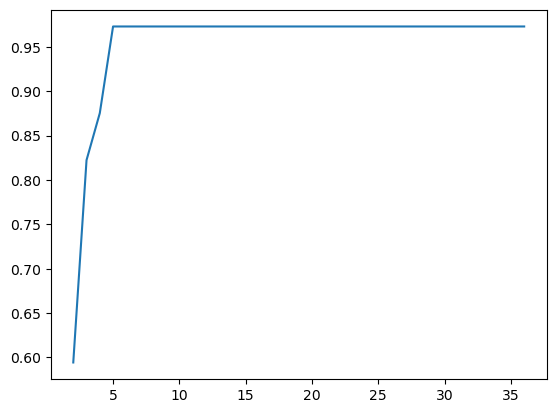

In [4]:
#kmeans for all data

# data
X = final.iloc[:, 0:768]

# scaler function
scaler = StandardScaler()

# scale the data
scaled_features = scaler.fit_transform(X)

# initialize vector for silhouette coefficients

silhouette_coefficients = []

# iterate through possible cluster amounts and apply kmeans

for k in range(2, 37):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# plot silhouette coefficients
plt.plot(range(2,37), silhouette_coefficients)

#ideal is 5...calculate for this and add to "final"

kmeans = KMeans(init = "random", n_clusters = 5, n_init = 10, max_iter = 300, random_state = 42)
kmeans.fit(scaled_features)

final.loc[:,'cluster'] = kmeans.labels_

In [ ]:
# okay but 5 doesnt make sense let's try 2

kmeans = KMeans(init = "random", n_clusters = 2, n_init = 10, max_iter = 300, random_state = 42)
kmeans.fit(scaled_features)
final.loc[:,'cluster'] = kmeans.labels_

In [ ]:
# the "good" half of the data
good_df = final[final['category'] == 'G']
good = good_df.iloc[:, 0:768]

good_scaled = scaler.fit_transform(good)

good_silhouette_coefficients = []

#same for loop
for k in range(2, 18):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    kmeans.fit(good_scaled)
    score = silhouette_score(good_scaled, kmeans.labels_)
    good_silhouette_coefficients.append(score)
    
plt.plot(range(2,18), good_silhouette_coefficients)

# ideal is 5

In [ ]:
# "bad" data
bad_df = final[final['category'] == 'B']
bad = bad_df.iloc[:, 0:768]

bad_scaled = scaler.fit_transform(bad)

bad_silhouette_coefficients = []

# same for loop
for k in range(2, 19):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    kmeans.fit(bad_scaled)
    score = silhouette_score(bad_scaled, kmeans.labels_)
    bad_silhouette_coefficients.append(score)
    
plt.plot(range(2,19), bad_silhouette_coefficients)

#ideal is 4

In [5]:
import pca as pca
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_features)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, final['cluster']], axis = 1)

In [ ]:
x = finalDf['principal component 1']
y = finalDf['principal component 2']
plt.scatter(x, y, c=finalDf['cluster'], alpha=0.5)
plt.show()

In [10]:
df1.drop_duplicates()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.039030,-0.086941,0.066183,-0.053097,-0.087962,-0.068795,-0.217095,-0.041003,0.047356,-0.002874,-0.010789,0.001914,-0.035281,0.065953,0.032943,0.025592,0.064494,0.058007,-0.021952,0.156676,-0.085778,0.033980,-0.108128,-0.009755,0.042683,...,-0.059958,0.026460,0.198716,0.099251,-0.024556,-0.097274,-0.057142,0.018027,0.001693,0.138355,0.101647,-0.037653,-0.037585,-0.089195,-0.013962,-0.054625,-0.014361,-0.063574,-0.019431,-0.174063,-0.002174,0.002537,0.121516,-0.125454,0.053616
2,-0.009720,-0.081880,0.106781,0.041525,-0.123429,-0.043841,-0.217286,-0.097202,0.000663,0.064409,0.017289,0.042813,0.017757,-0.031487,0.137280,-0.023062,0.008646,0.079860,-0.060788,0.173512,-0.148557,0.040863,0.001970,-0.034032,-0.010577,...,0.054208,0.022216,0.187954,0.212609,0.029206,-0.107148,-0.016082,-0.000909,-0.007651,-0.109760,0.010323,-0.025526,0.006802,-0.061828,-0.032853,-0.155281,0.004749,0.086047,0.057976,-0.202903,-0.044898,-0.021528,0.242567,-0.065737,-0.062649
3,0.147399,-0.095851,0.142954,-0.106241,-0.012254,-0.095917,-0.217286,-0.113740,0.091689,0.080804,-0.083746,0.106492,-0.038799,0.113077,0.004294,-0.178117,0.128131,0.064309,-0.011330,0.123660,-0.023536,0.110805,-0.090541,-0.052150,0.043946,...,0.050900,0.004761,0.161291,0.066715,-0.042453,-0.001744,0.065781,0.035206,-0.038102,0.046104,0.059788,-0.039233,-0.088627,-0.158248,-0.099372,0.043514,0.074937,-0.038973,-0.058922,-0.154869,0.078405,-0.042030,0.102986,-0.062511,-0.113120
5,-0.025272,-0.081084,0.193862,0.160525,-0.008502,-0.096821,-0.221240,-0.008060,-0.131907,-0.143298,-0.169097,0.290681,-0.072676,-0.322109,0.030075,-0.053443,0.066640,0.178125,-0.007738,0.225445,0.077549,-0.059251,0.261462,-0.062177,0.018564,...,0.059017,0.231748,0.144958,0.168369,-0.201428,-0.096312,-0.190247,0.014375,0.085794,0.088493,-0.249973,0.055531,-0.162203,-0.171385,0.071432,0.081647,-0.176273,-0.049244,-0.000223,-0.186317,-0.198262,-0.097490,0.053789,0.142623,-0.145674
7,-0.037293,0.011009,0.055412,-0.066392,-0.073041,-0.039873,-0.217285,-0.001084,0.049005,-0.063712,0.135720,0.049350,0.041995,-0.039115,0.064111,-0.098084,0.112893,0.077284,-0.014651,0.137914,0.028586,0.018378,-0.111337,0.038305,0.026590,...,-0.077039,-0.080395,0.211426,0.109116,0.024911,-0.036544,-0.060996,0.039971,-0.005585,0.095389,0.058600,-0.004908,-0.040582,-0.119355,0.017407,-0.003431,0.063120,-0.066817,-0.011499,-0.168559,0.003505,-0.062214,0.105612,-0.187919,0.063430


In [6]:
scaled_features

array([[-0.23702163, -0.16967855, -1.0731889 , ..., -0.39847475,
        -0.76831764,  1.2091033 ],
       [-0.23702163, -0.16967855, -1.0731889 , ..., -0.39847475,
        -0.76831764,  1.2091033 ],
       [-0.9543767 ,  0.04878046,  0.05148238, ...,  1.6099724 ,
         0.3667343 , -0.3467134 ],
       ...,
       [ 1.3576229 , -0.55425876,  1.0535622 , ..., -0.7059265 ,
         0.42805138, -1.0221026 ],
       [-0.9543767 ,  0.04878046,  0.05148238, ...,  1.6099724 ,
         0.3667343 , -0.3467134 ],
       [-0.9543767 ,  0.04878046,  0.05148238, ...,  1.6099724 ,
         0.3667343 , -0.3467134 ]], dtype=float32)